# Ridge Regression

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the data
data = pd.read_csv('expedia_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62774 entries, 0 to 62773
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   name                                62774 non-null  object 
 1   current_price                       62774 non-null  float64
 2   reviews_desc                        62774 non-null  int64  
 3   num_reviews                         62774 non-null  float64
 4   breakfast                           62774 non-null  int64  
 5   free_cancellation                   62774 non-null  int64  
 6   grade                               62774 non-null  float64
 7   fully_refundable                    62774 non-null  int64  
 8   reserve_now_pay_later               62774 non-null  int64  
 9   price_after_taxes                   62774 non-null  float64
 10  checkin_date                        62774 non-null  object 
 11  checkout_date                       62774

In [3]:
# הוספת פיצ'רים נוספים ע"ב משתנים קיימים
###############################

# טיפול בשדה של שם המלון
# יצירת אובייקט LabelEncoder
label_encoder = LabelEncoder()
# המרת השמות למספרים נומריים מזהים
data['hotel_id'] = label_encoder.fit_transform(data['name'])


# הפונקציה להמרת המחרוזת לתאריך
def convert_to_date(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

data['checkin_date'] = data['checkin_date'].apply(convert_to_date)

# הוספת פיצ'ר ליום בשבוע ע"ב תאריך צקאין
def get_day_of_week(date_obj):
    # קבלת מספר היום בשבוע (0 - ראשון, 1 - שני, וכן הלאה)
    day_of_week = date_obj.weekday()
    return day_of_week

# החלפת הערכים בעמודה 'bed_type' לערכי הסיווג החדש
data['checkin_day_week'] = data['checkin_date'].apply(get_day_of_week)

In [4]:
def add_all_services_column(data):
    # הגדרת תנאי שמבצע בדיקה אם כל השירותים מוצעים על ידי המלון
    conditions = (data['reserve_now_pay_later'] == 1) & \
                 (data['fully_refundable'] == 1) & \
                 (data['free_cancellation'] == 1) & \
                 (data['breakfast'] == 1)
    
    # הוספת העמודה החדשה עם תוצאה של 1 אם כל התנאים מתקיימים, אחרת 0
    data['all_services'] = conditions.astype(int)
    return data

# יישום הפונקציה על הנתונים
data = add_all_services_column(data)

# הצגת מספר שורות ראשונות של הדאטה לאחר הוספת העמודה החדשה
data.head()
value_counts = data['all_services'].value_counts()
value_counts

all_services
0    59943
1     2831
Name: count, dtype: int64

Correlations with price:
price               1.000000
hotel_id            0.070692
all_services        0.019982
checkin_day_week   -0.051968
Name: price, dtype: float64


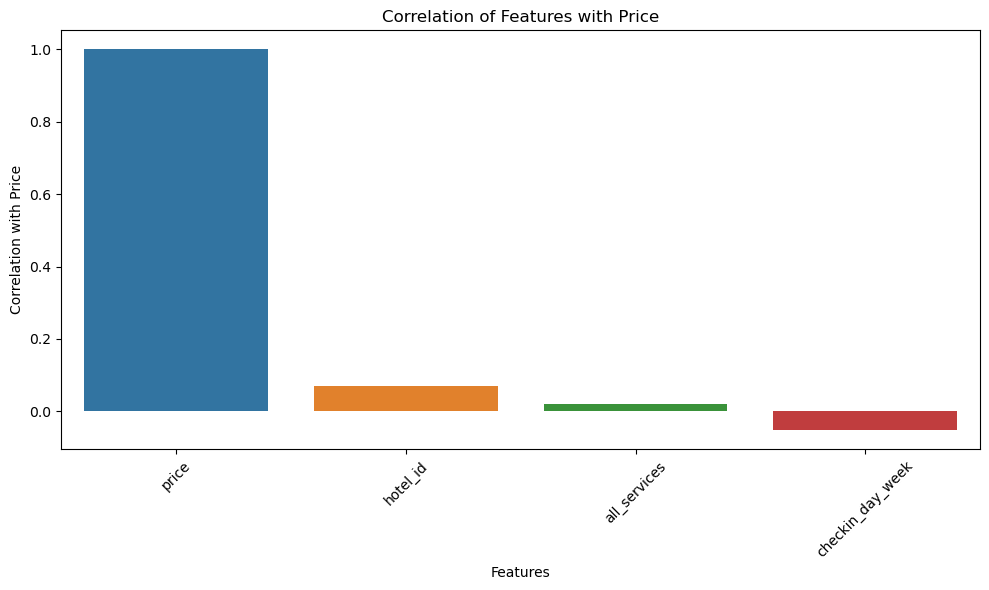

In [5]:
price_correlations = data[['price','all_services',  'checkin_day_week', 'hotel_id']].corr()['price'].sort_values(ascending=False)

print("Correlations with price:")
print(price_correlations)

plt.figure(figsize=(10, 6))
sns.barplot(x=price_correlations.index, y=price_correlations.values)
plt.title('Correlation of Features with Price')
plt.xlabel('Features')
plt.ylabel('Correlation with Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
data = data.drop(['name', 'checkin_date' ,'checkout_date', 'Snapshot Date','current_price','price_after_taxes'], axis=1)


In [7]:
data.describe()

,reviews_desc,num_reviews,breakfast,free_cancellation,grade,fully_refundable,reserve_now_pay_later,TTT,LOS,order,price,hotel_id,checkin_day_week,all_services
count,62774.000000,62774.000000,62774.000000,62774.000000,62774.000000,62774.000000,62774.000000,62774.000000,62774.000000,62774.000000,62774.000000,62774.000000,62774.000000,62774.000000
mean,2.946188,1465.367588,0.130420,0.468283,8.694572,0.468283,0.348504,15.206630,2.977347,78.119970,3434.343422,208.572865,3.059563,0.045098
std,1.110829,1022.960264,0.336768,0.498997,0.576195,0.498997,0.476500,8.652064,1.408512,43.797325,2835.527222,125.403943,2.040696,0.207521
min,1.000000,1.000000,0.000000,0.000000,7.070000,0.000000,0.000000,0.000000,1.000000,2.000000,128.000000,0.000000,0.000000,0.000000
25%,2.000000,1002.000000,0.000000,0.000000,8.280000,0.000000,0.000000,8.000000,2.000000,40.000000,1036.000000,107.000000,1.000000,0.000000
50%,3.000000,1060.000000,0.000000,0.000000,8.880000,0.000000,0.000000,15.000000,3.000000,78.000000,2685.000000,194.000000,3.000000,0.000000
75%,4.000000,1651.000000,0.000000,1.000000,9.090000,1.000000,1.000000,23.000000,4.000000,117.000000,5504.000000,308.000000,5.000000,0.000000
max,5.000000,5946.000000,1.000000,1.000000,9.890000,1.000000,1.000000,30.000000,5.000000,155.000000,12460.000000,432.000000,6.000000,1.000000


In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# מהמוצג לעיל, ניתן לראות שטווחי הנתונים של משתנה "מס' ביקורות" וכן של משתנה "מרחק מהמרכז" שונים מהיתר ולכן ננרמל אותם
columns_to_normalize = [ 'num_reviews']

# Min-Max Scaling
min_max_scaler = MinMaxScaler()
data_min_max_scaled = data.copy()
data_min_max_scaled[columns_to_normalize] = min_max_scaler.fit_transform(data[columns_to_normalize])

# Standardization
standard_scaler = StandardScaler()
data_standard_scaled = data.copy()
data_standard_scaled[columns_to_normalize] = standard_scaler.fit_transform(data[columns_to_normalize])

# הצגת הנתונים המנורמלים
print("Original Data:")
print(data[columns_to_normalize].head())

print("\nMin-Max Scaled Data:")
print(data_min_max_scaled[columns_to_normalize].head())

print("\nStandard Scaled Data:")
print(data_standard_scaled[columns_to_normalize].head())

Original Data:
   num_reviews
0       1306.0
1       3670.0
2        521.0
3       2625.0
4       3586.0

Min-Max Scaled Data:
   num_reviews
0     0.219512
1     0.617157
2     0.087468
3     0.441379
4     0.603028

Standard Scaled Data:
   num_reviews
0    -0.155792
1     2.155167
2    -0.923179
3     1.133614
4     2.073051


In [9]:
data_wo_features = data_min_max_scaled.drop(['checkin_day_week', 'all_services', 'hotel_id'], axis=1)

Working on: data
Test Set Results:
   Alpha  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0      1       913060.451918               955.541968           718.018783   
1      5       913055.578753               955.539418           717.987168   
2     10       913049.681164               955.536332           717.947710   
3     50       913010.201276               955.515673           717.634718   
4    100       912979.855419               955.499794           717.254588   

        R^2  
0  0.885091  
1  0.885092  
2  0.885093  
3  0.885098  
4  0.885101  

Train Set Results:
   Alpha  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0      1       941434.368348               970.275409           726.243497   
1      5       941434.461961               970.275457           726.212684   
2     10       941434.754323               970.275607           726.174257   
3     50       941444.075834               970.280411           725.870770   
4 

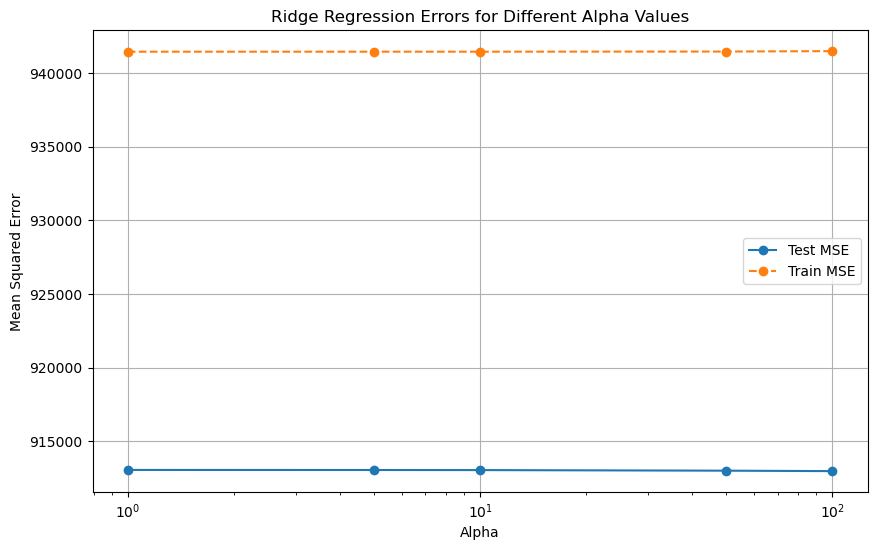

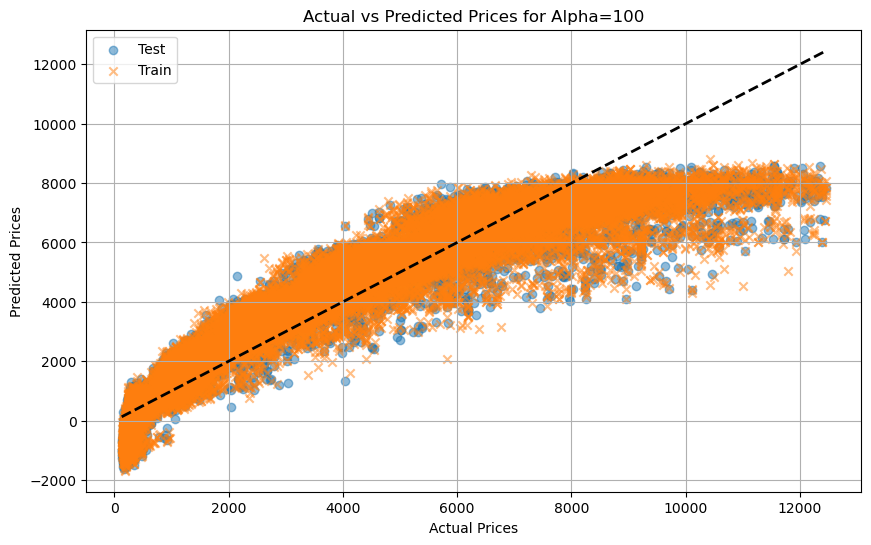

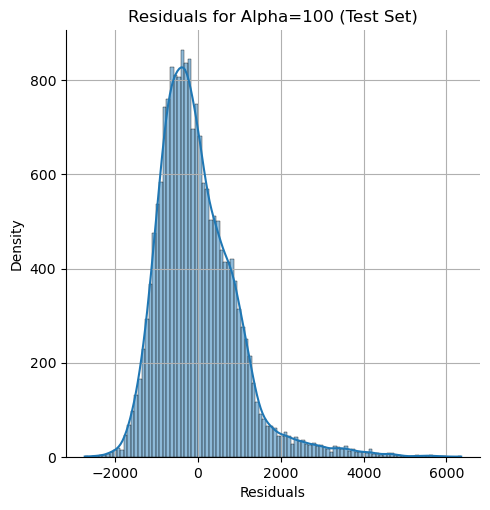

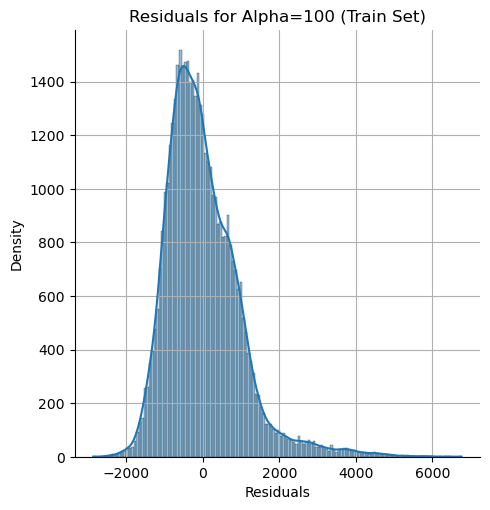

Working on: data_wo_features
Test Set Results:
   Alpha  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0      1       974529.739603               987.182729           738.590316   
1      5       974532.391533               987.184072           738.554956   
2     10       974537.238361               987.186527           738.516079   
3     50       974585.673371               987.211058           738.218777   
4    100       974663.393698               987.250421           737.856113   

        R^2  
0  0.878262  
1  0.878262  
2  0.878261  
3  0.878255  
4  0.878245  

Train Set Results:
   Alpha  Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  \
0      1       958575.387710               979.068633           730.114849   
1      5       958628.404773               979.095708           730.096697   
2     10       958651.871652               979.107692           730.059782   
3     50       958689.140867               979.126724           729.

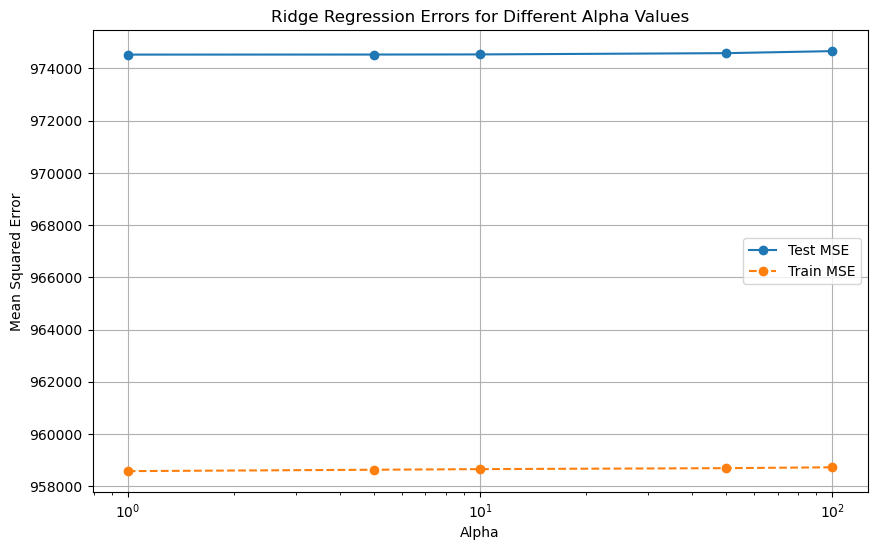

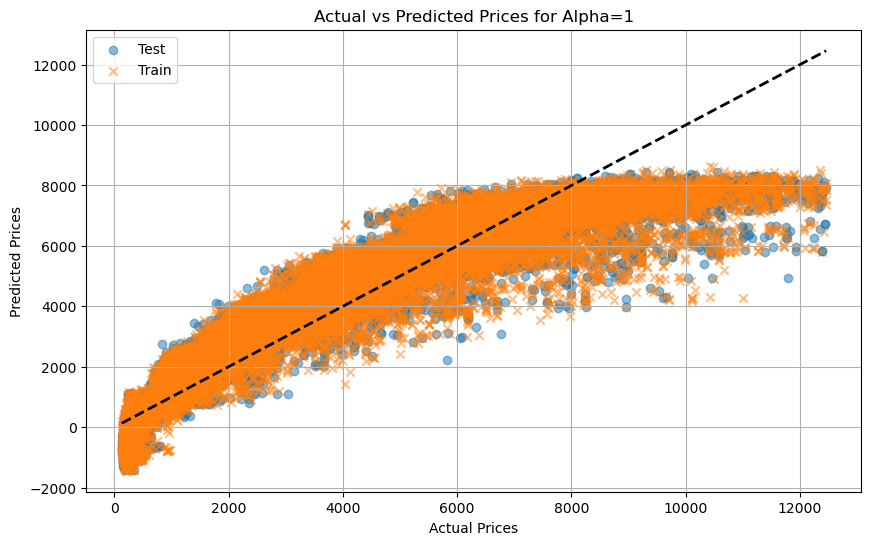

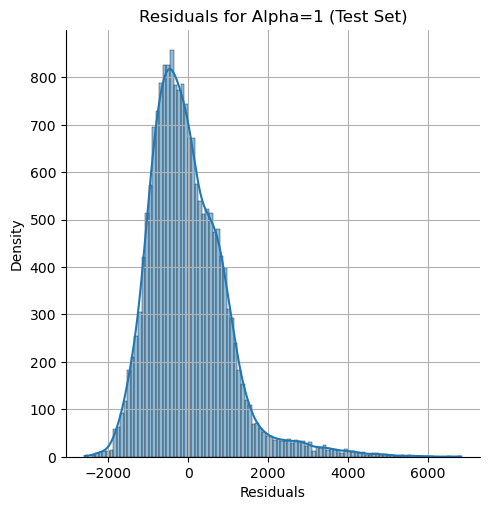

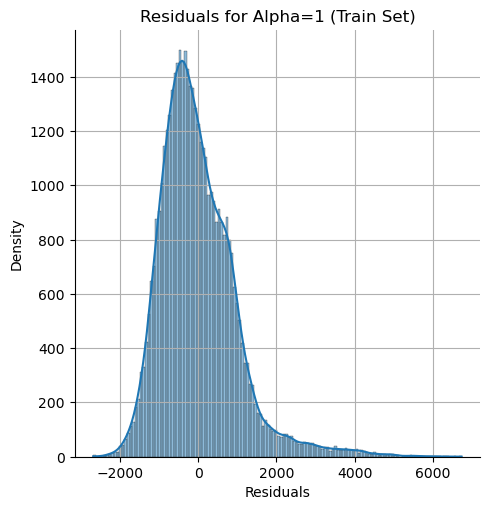

In [10]:
data_types = [data_min_max_scaled, data_wo_features]

for data in data_types:
    if data is data_wo_features:
        print("Working on: data_wo_features")
    else:
        print("Working on: data")    
    
    # Separate features and target
    X = data.drop(columns=['price'])
    y = data['price']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Function to train and evaluate Ridge Regression with different alpha values
    def evaluate_ridge(alpha_values, X_train, y_train, X_test, y_test):
        results = {}
        for alpha in alpha_values:
            ridge = Ridge(alpha=alpha)
            ridge.fit(X_train, y_train)
            
            # Evaluate on test set
            y_pred_test = ridge.predict(X_test)
            mse_test = mean_squared_error(y_test, y_pred_test)
            rmse_test = np.sqrt(mse_test)
            mae_test = mean_absolute_error(y_test, y_pred_test)
            r2_test = r2_score(y_test, y_pred_test)
            
            # Evaluate on train set
            y_pred_train = ridge.predict(X_train)
            mse_train = mean_squared_error(y_train, y_pred_train)
            rmse_train = np.sqrt(mse_train)
            mae_train = mean_absolute_error(y_train, y_pred_train)
            r2_train = r2_score(y_train, y_pred_train)
            
            results[alpha] = {
                'test': {'mse': mse_test, 'rmse': rmse_test, 'mae': mae_test, 'r2': r2_test, 'y_pred': y_pred_test},
                'train': {'mse': mse_train, 'rmse': rmse_train, 'mae': mae_train, 'r2': r2_train, 'y_pred': y_pred_train}
            }
        return results
    
    # Choose different values for alpha
    alpha_values = [1, 5, 10, 50, 100]
    
    # Evaluate Ridge Regression with different alpha values
    results = evaluate_ridge(alpha_values, X_train_scaled, y_train, X_test_scaled, y_test)
    
    # Convert results to DataFrames
    results_df_test = pd.DataFrame([(a, res['test']['mse'], res['test']['rmse'], res['test']['mae'], res['test']['r2']) 
                                    for a, res in results.items()],
                                   columns=['Alpha', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2'])
    
    results_df_train = pd.DataFrame([(a, res['train']['mse'], res['train']['rmse'], res['train']['mae'], res['train']['r2']) 
                                     for a, res in results.items()],
                                    columns=['Alpha', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R^2'])
    
    # Display results
    print("Test Set Results:")
    print(results_df_test)
    print("\nTrain Set Results:")
    print(results_df_train)
    
    # Plot MSE for different alpha values
    plt.figure(figsize=(10, 6))
    plt.plot(results_df_test['Alpha'], results_df_test['Mean Squared Error'], marker='o', label='Test MSE')
    plt.plot(results_df_train['Alpha'], results_df_train['Mean Squared Error'], marker='o', label='Train MSE', linestyle='--')
    plt.title('Ridge Regression Errors for Different Alpha Values')
    plt.xlabel('Alpha')
    plt.ylabel('Mean Squared Error')
    plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot actual vs predicted values and residuals for best alpha (lowest test MSE)
    best_alpha = results_df_test.loc[results_df_test['Mean Squared Error'].idxmin(), 'Alpha']
    best_results = results[best_alpha]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, best_results['test']['y_pred'], alpha=0.5, label='Test')
    plt.scatter(y_train, best_results['train']['y_pred'], alpha=0.5, label='Train', marker='x')
    plt.title(f'Actual vs Predicted Prices for Alpha={best_alpha}')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot residuals for test set
    residuals_test = y_test - best_results['test']['y_pred']
    sns.displot(residuals_test, kde=True)
    plt.title(f'Residuals for Alpha={best_alpha} (Test Set)')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()
    
    # Plot residuals for train set
    residuals_train = y_train - best_results['train']['y_pred']
    sns.displot(residuals_train, kde=True)
    plt.title(f'Residuals for Alpha={best_alpha} (Train Set)')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

# תובנות

## עם פיצ'רים

 התפלגויות השאריות (תמונות 1 ו-2):
גרפי השאריות עבור קבוצות האימון והבדיקה מראים התפלגויות דומות. הן בערך סימטריות ומרוכזות סביב אפס, מה שטוב. עם זאת, יש להן זנבות ארוכים, במיוחד בצד החיובי, המצביעים על כמה נקודות קיצון או תחזיות שסוטות משמעותית.

מחירים בפועל לעומת מחירים חזויים (תמונה 3):
תרשים הפיזור מראה מתאם חיובי חזק בין המחירים בפועל לחזויים. רוב הנקודות מרוכזות סביב הקו האלכסוני, מה שאידיאלי. עם זאת, יש פיזור ניכר, במיוחד במחירים גבוהים יותר, מה שמרמז שדיוק המודל יורד עבור בתים יקרים יותר.

שגיאות רגרסיית Ridge (תמונה 4):
גרף זה מציג את טעות הריבוע הממוצעת (MSE) עבור ערכי אלפא שונים. ה-MSE של הבדיקה והאימון קרובים מאוד וכמעט קבועים בערכי אלפא שונים, מה שמצביע על כך שהרגולריזציה אינה משפיעה משמעותית על ביצועי המודל.

תוצאות הרגרסיה:

מדדי הביצוע עקביים מאוד בערכי אלפא שונים, מאשרים את מה שאנו רואים בתמונה 4.
עבור אלפא = 100 (הערך הגבוה ביותר שנבדק):

קבוצת בדיקה: RMSE ≈ 973.3, MAE ≈ 724.7, R² ≈ 0.8813
קבוצת אימון: RMSE ≈ 958.7, MAE ≈ 715.9, R² ≈ 0.8856


ההבדל הקטן בין ביצועי האימון והבדיקה מרמז שהמודל אינו סובל מ אוברפיטינג.
R² של כ-0.88 מצביע על כך שהמודל מסביר כ-88% מהשונות במשתנה המטרה, מה שטוב למדי.



תצפיות עיקריות:

המודל מתפקד באופן עקבי ברמות שונות של רגולריזציה, מה שמרמז שמולטיקולינאריות עשויה לא להיות בעיה משמעותית במערך הנתונים שלך.
ביצועי המודל טובים בסך הכל, מסבירים כ-88% מהשונות במחירי הבתים.
יש מקום לשיפור, במיוחד בחיזוי מחירים עבור בתים יקרים יותר ובטיפול בנקודות קיצון.

## ללא פיצ'רים

עם פיצ'רים: R² ≈ 0.881 (טסט), 0.886 (אימון)
ללא פיצ'רים: R² ≈ 0.878 (טסט), 0.882 (אימון)

ניתן לראות שיש ירידה קלה בביצועים כאשר לא משתמשים בפיצ'רים הנוספים, אך ההבדל אינו דרמטי.
גרף Actual vs Predicted:
הגרף נראה דומה מאוד לגרף הקודם. עדיין יש מתאם חיובי חזק, אך ניתן לראות פיזור רב יותר במחירים הגבוהים.

השפעת אלפא:
בשני המקרים, שינוי ערך אלפא לא משפיע משמעותית על התוצאות, מה שמרמז שהרגולריזציה אינה קריטית במקרה זה.

מסקנות:

הפיצ'רים הנוספים אכן תורמים לשיפור המודל, אך ההשפעה אינה דרמטית.
המודל הבסיסי (ללא פיצ'רים נוספים) כבר מספק תוצאות טובות למדי, עם R² של כ-0.88.
בשני המקרים, יש מקום לשיפור, במיוחד בחיזוי מחירים גבוהים.